In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.datasets import fashion_mnist
import numpy as np
from matplotlib import pyplot as plt
from data_augmentation import data_augmentation
from metrics import plot_ROC_curve, plot_confusion_matrix
from models import create_mlp_model, plot_accuracy, plot_loss
from tensorflow import keras

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Sparse arrays

In [5]:
y_sparse_train = np.zeros([len(y_train),10])
y_sparse_test = np.zeros([len(y_test),10])

In [6]:
for idx in range(len(y_train)):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(len(y_test)):
    y_sparse_test[idx,y_test[idx]] = 1

## Models

In [7]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from keras import Model
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from keras.models import Sequential
from keras.utils import plot_model
from keras.initializers import GlorotUniform, GlorotNormal, RandomNormal
from keras.backend import clear_session

### Softmax Regression

In [8]:
model_best = Sequential()

In [9]:
model_best.add(Flatten(input_shape=(28,28)))

In [10]:
model_best.add(BatchNormalization())

In [11]:
model_best.add(Dense(256, activation="relu"))

In [12]:
model_best.add(Dropout(0.125))

In [13]:
model_best.add(Dense(128, activation="relu"))

In [14]:
model_best.add(Dense(2, activation="relu"))

In [15]:
model_best.add(Dense(10, activation="softmax"))

In [16]:
model_best.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                        

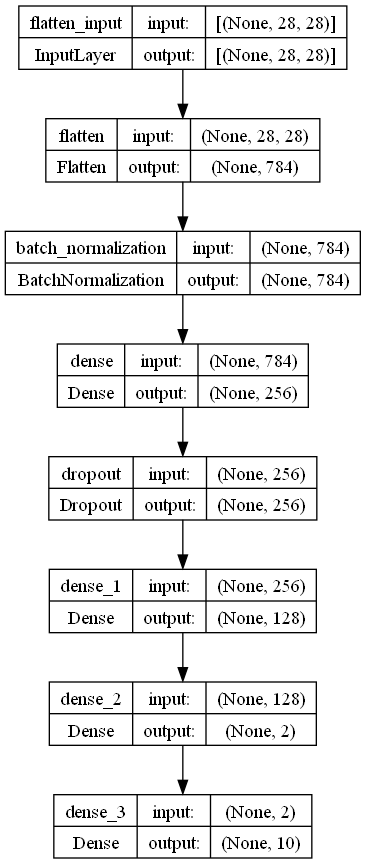

In [17]:
plot_model(model_best, show_shapes=True, show_layer_names=True, to_file='best_model.png')

In [18]:
model_best.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

### Train

In [19]:
history_best = model_best.fit(x=X_train, y=y_sparse_train, validation_data=(X_test, y_sparse_test), batch_size=128, epochs=20)

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 1.4670 - accuracy: 0.4714 - val_loss: 1.1312 - val_accuracy: 0.6357
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 1.0107 - accuracy: 0.7067 - val_loss: 0.9257 - val_accuracy: 0.7828
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.8277 - accuracy: 0.8089 - val_loss: 0.7948 - val_accuracy: 0.8204
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.6988 - accuracy: 0.8290 - val_loss: 0.7151 - val_accuracy: 0.8226
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.6212 - accuracy: 0.8415 - val_loss: 0.6481 - val_accuracy: 0.8413
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.5672 - accuracy: 0.8513 - val_loss: 0.6218 - val_accuracy: 0.8373
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.5175 - accuracy: 0.8576 - val_loss: 0.5905 - val_accuracy: 0.8480
Epoch 

In [20]:
model_best_input = Model(inputs=model_best.input, outputs=model_best.layers[-2].output)
model_best_output = Model(inputs=model_best.layers[-1].input, outputs=model_best.layers[-1].output)

In [21]:
model_best_input.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                             

In [22]:
model_best_output.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 10)                30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [23]:
X_train_hat = model_best_input.predict(X_train)

1875/1875 [==============================] - 2s 815us/step


313/313 [==============================] - 0s 562us/step


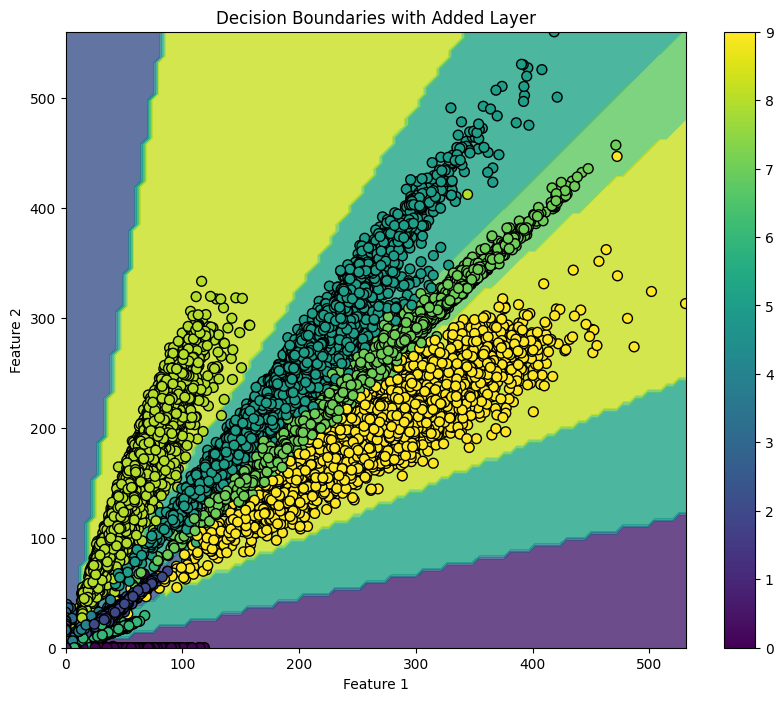

In [24]:
x_min, x_max = X_train_hat[:, 0].min() - 0.1, X_train_hat[:, 0].max() + 0.1
y_min, y_max = X_train_hat[:, 1].min() - 0.1, X_train_hat[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Flatten the meshgrid coordinates and make predictions
meshgrid_data = np.c_[xx.ravel(), yy.ravel()]
predictions = model_best_output.predict(meshgrid_data)

# Reshape the predictions and create a contour plot
predictions = np.argmax(predictions, axis=1)
predictions = predictions.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, predictions, alpha=0.8)
plt.scatter(X_train_hat[:, 0], X_train_hat[:, 1], c=y_train, edgecolors='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries with Added Layer')
plt.colorbar()
plt.show()